In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
## Load dataset
data_path = "../gmm_dataset_c20k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()

NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_LOCAL = 32

BATCH_SIZE = 20
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'baseline-mlp-%dsamples' % (SAMPLE_SIZE)
DEVICE = torch.device('cuda:0')

Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (N, K, D)

In [3]:
from local_enc import *
from global_oneshot import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)
if CUDA:
    enc_z.cuda().to(DEVICE)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)
if CUDA:
    oneshot_eta.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
models = (oneshot_eta, enc_z)

In [4]:
enc_z.load_state_dict(torch.load("../weights/enc-z-%s" % PATH))
oneshot_eta.load_state_dict(torch.load("../weights/oneshot-eta-%s" % PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
def EP_test(models, obs, SubTrain_Params):
    """
    oneshot encoder using exact same architecture from amor-gibbs
    initialize eta
    """
    (device, sample_size, batch_size, N, K, D) = SubTrain_Params
    (oneshot_eta, enc_z) = models
    q_eta, p_eta, q_nu = oneshot_eta(obs, K, D)
    obs_mu = q_eta['means'].value
    obs_tau = q_eta['precisions'].value
    q_z, p_z = enc_z.forward(obs, obs_tau, obs_mu, N, K, sample_size, batch_size)
    reused = (q_eta, q_z)
    return reused

def test(models, objective, Data, Model_Params, Train_Params):
    (NUM_EPOCHS, NUM_DATASETS, S, B, CUDA, device, path) = Train_Params
    SubTrain_Params = (device, S, B) + Model_Params
    ##(N, K, D, mcmc_size) = Model_Params
    indices = torch.randperm(NUM_DATASETS)
    batch_indices = indices[0*B : (0+1)*B]
    obs = Data[batch_indices]
    obs = shuffler(obs).repeat(S, 1, 1, 1)
    if CUDA:
        obs =obs.cuda().to(device)
    reused = objective(models, obs, SubTrain_Params)
    return obs, reused

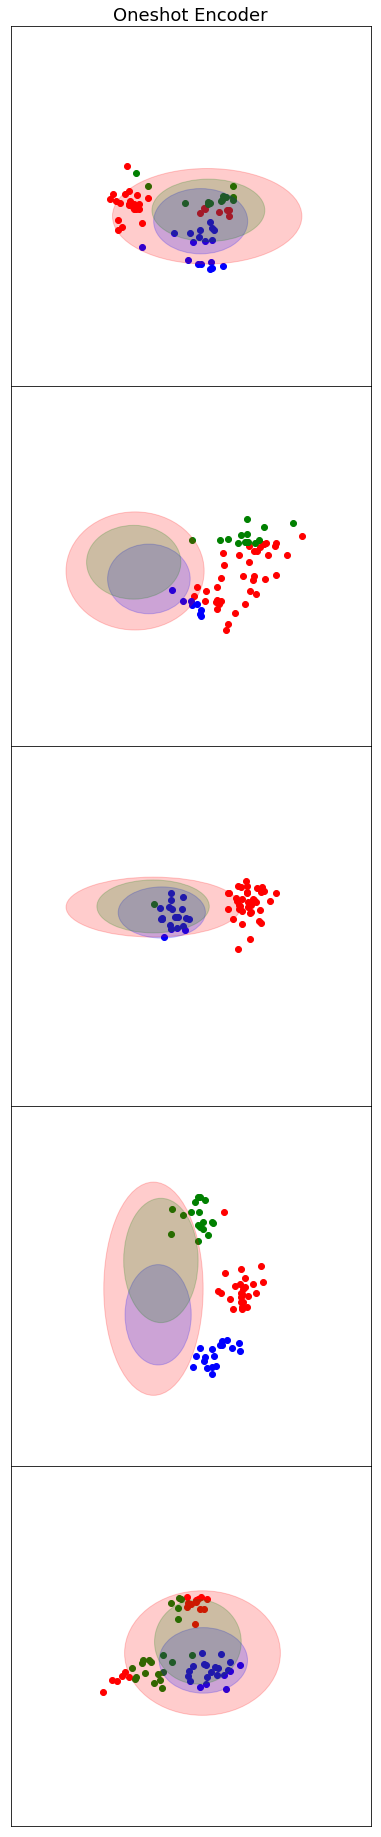

In [6]:
SAMPLE_SIZE = 10
BATCH_SIZE = 5
##
colors = ['r', 'b', 'g']
gs = gridspec.GridSpec(BATCH_SIZE, 1)
gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
fig = plt.figure(figsize=(5,25))

indices = torch.arange(NUM_DATASETS)
step = 2
batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
obs = Data[batch_indices]
obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    obs =obs.cuda().to(DEVICE)


SubTrain_Params = (DEVICE, SAMPLE_SIZE, BATCH_SIZE) + (N, K, D)
reused = EP_test(models, obs, SubTrain_Params)
(q_eta, q_z) = reused
xs = obs[0].cpu().data.numpy()
E_z = q_z['zs'].dist.probs[0].cpu().data.numpy()
E_mu = q_eta['means'].dist.loc[0].cpu().data.numpy()
E_tau = (q_eta['precisions'].dist.concentration[0] / q_eta['precisions'].dist.rate[0]).cpu().data.numpy()
for b in range(BATCH_SIZE):
    ax = fig.add_subplot(gs[b, 0])
    xb = xs[b]
    zb = E_z[b]
    mu = E_mu[b].reshape(K, D)
    sigma2 = 1. / E_tau[b]
    assignments = zb.argmax(-1)
    for k in range(K):
        cov_k = np.diag(sigma2[k])
        xk = xb[np.where(assignments == k)]
        ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
        plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
    ax.set_ylim([-15, 15])
    ax.set_xlim([-15, 15])
    ax.set_xticks([])
    ax.set_yticks([])
    if b == 0:
        ax.set_title("Oneshot Encoder", fontsize=18)
plt.savefig('../results/propagation' + PATH + '.svg')

In [ ]:
%time plot_samples(obs, q_eta, q_z, PATH)

In [ ]:
incremental_gap